# Semantic Segmentation
![대체 텍스트](https://miro.medium.com/max/700/1*8Nwk_IdGpe235Nsfewpucg.png)

from Fei-Fei Li Stanford Course — Detection And Segmentation

## STEP 1: 데이터셋과 읽어들이기
https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

![대체 텍스트](https://www.altoros.com/blog/wp-content/uploads/2018/12/segmentation-results-max-dice-score.png)

**Lung_Segmentation.zip**  
**256x256x3**  
**566 [image, label]**  

In [2]:
!wget https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip

--2023-10-17 16:35:10--  https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip
Resolving github.com (github.com)... 20.200.245.247
Connecting to github.com (github.com)|20.200.245.247|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip [following]
--2023-10-17 16:35:10--  https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56097894 (53M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>] 

In [ ]:
!unzip Lung_Segmentation.zip

In [1]:
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "./"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)
#print(file_headers)

X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

count = 0
for fh in file_headers:
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))

    img = imread(f1)[:,:,:IMG_CHANNELS]
    mask = imread(l1)
    mask = np.expand_dims(mask, axis=-1)

    X_all[count] = img
    y_all[count] = mask

    count += 1

**딥러닝을 위한 데이터 전처리**

In [2]:
X_all = X_all.astype('float32') / 255.
y_all = y_all.astype('float32')

**학습, 검증, 테스트 데이터 셋으로 분리**

In [3]:
# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [4]:
print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 1)
y_valid (91, 256, 256, 1)
y_test (114, 256, 256, 1)


## STEP 2: 데이터 살펴보기

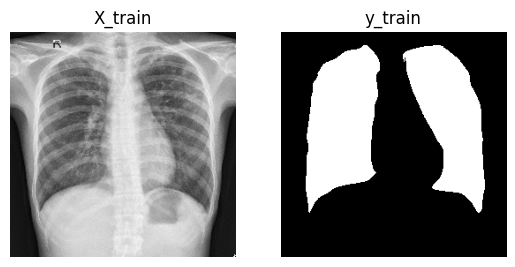

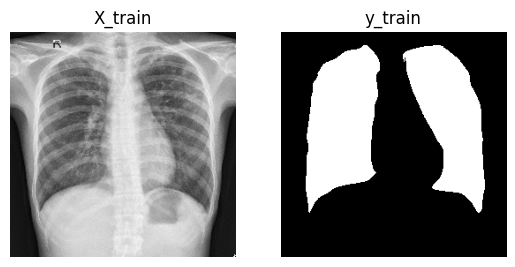

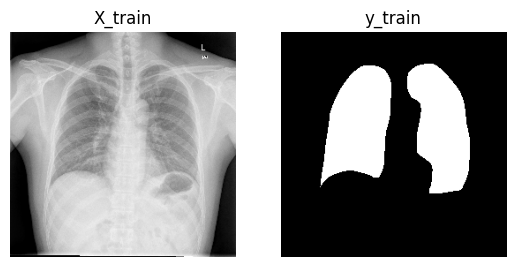

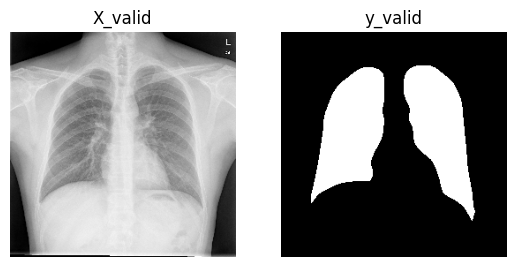

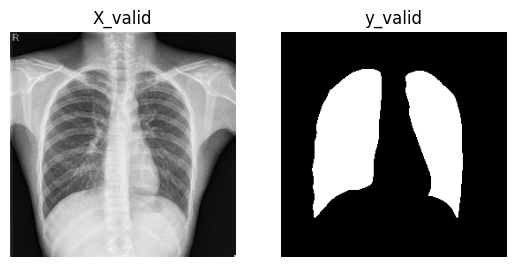

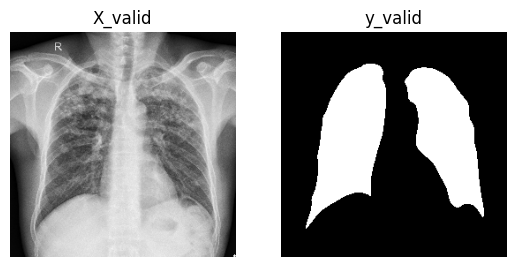

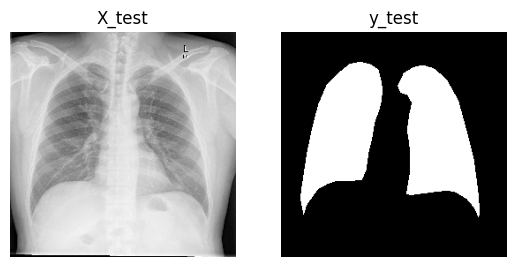

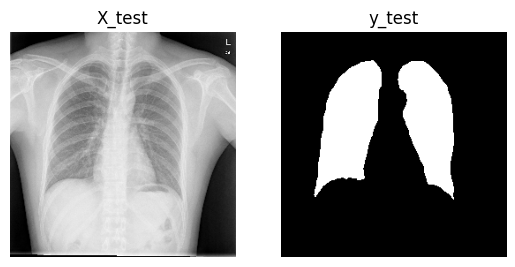

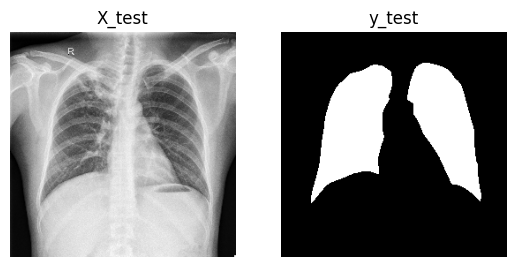

In [5]:
import matplotlib.pyplot as plt

def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]), 'gray')
        plt.axis('off')
        plt.show()

plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')
plotTrainData(X_test,y_test, 'test')

## STEP 3: VGG16 네트워크 다시 보기
![대체 텍스트](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

def vgg16():
    inputs = Input(shape=(256, 256, 3,), name="VGGInput")

    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)

    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)

    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)

    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    x = Flatten()(x)
    x = Dense(4096, activation=relu)(x)
    pred = Dense(1000, activation=softmax)(x)

    return Model(inputs=inputs, outputs=pred)

2023-10-18 15:27:34.815504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


**FCN 32 - first fully convolutional network**
![image interpolation](https://matplotlib.org/_images/interpolation_methods.png)
**image interpolation**

## STEP 4: 첫 번째 영상분할 모델 (FCN32s)

In [9]:
from tensorflow.keras.layers import Activation

def fcn32s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")

    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)

    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)

    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)

    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)

    conv_t1 = UpSampling2D(size = (32,32))(pool_5)
    conv_t2 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv_t1)

    pred = Activation('sigmoid')(conv_t2)

    return Model(inputs=inputs, outputs=pred)

![대체 텍스트](https://jinglescode.github.io/assets/img/posts/unet-03.webp)
![대체 텍스트](https://miro.medium.com/max/875/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [8]:
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [7]:
from tensorflow.keras.optimizers import SGD

# build the model
model = fcn32s()
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-32s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

NameError: name 'fcn32s' is not defined

## STEP 5: 결과 확인하기

In [10]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN

    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    preds_valid_t = (preds_valid > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_valid")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_valid")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_valid_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

## STEP 6: 두 번째 모델 (FCN8s)
**Skip Connection**
![대체 텍스트](http://deeplearning.net/tutorial/_images/fcn_schema.png)

In [ ]:
def fcn8s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")

    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)

    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)

    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)

    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)

    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)

    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    conv_t1 = UpSampling2D(size = (2,2))(conv8)
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    conv_t2 = UpSampling2D(size = (2,2))(fuse_1)
    fuse_2 = Add()([conv_t2,score_pool3])

    conv_t3 = UpSampling2D(size = (8,8))(fuse_2)

    pred = Activation('sigmoid')(conv_t3)

    return Model(inputs=inputs, outputs=pred)


In [ ]:
# build the model
model = fcn8s()
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-8s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

## STEP 6-1: 두 번째 모델 (FCN8s)의 개선시도 -> (FCN2s)
**Skip Connection**

In [ ]:
def fcn2s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")

    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)

    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)

    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)

    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)

    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)

    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    conv_t1 = UpSampling2D(size = (2,2))(conv8)
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    conv_t2 = UpSampling2D(size = (2,2))(fuse_1)
    fuse_2 = Add()([conv_t2,score_pool3])

    #(64, 64)
    score_pool2 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_2)
    conv_t3 = UpSampling2D(size = (2,2))(fuse_2)
    fuse_3 = Add()([conv_t3,score_pool2])

    #(128, 128)
    score_pool1 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_1)
    conv_t4 = UpSampling2D(size = (2,2))(fuse_3)
    fuse_4 = Add()([conv_t4,score_pool1])

    conv_t5 = UpSampling2D(size = (2,2))(fuse_4)

    pred = Activation('sigmoid')(conv_t5)

    return Model(inputs=inputs, outputs=pred)

In [ ]:
# build the model
model = fcn2s()
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-2s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

## STEP 7: 세 번째 모델 (FCN8s with deconvolution)
**deconvolution**  
![대체 텍스트](https://miro.medium.com/max/1086/1*AbCrAqPBfkqGRdhKtiZQqA.png)

In [ ]:
def fcn8s_deconv():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")

    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)

    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)

    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)

    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)

    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)

    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)

    conv_t1 = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2), padding="same")(conv8)
    conv_t1 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t1)
    conv_t1 = BatchNormalization()(conv_t1)
    conv_t1 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t1)
    conv_t1 = BatchNormalization()(conv_t1)

    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)

    conv_t2 = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2),padding="same")(fuse_1)
    conv_t2 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t2)
    conv_t2 = BatchNormalization()(conv_t2)
    conv_t2 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t2)
    conv_t2 = BatchNormalization()(conv_t2)

    fuse_2 = Add()([conv_t2,score_pool3])

    #(32, 32) x 8 = 256
    conv_t3 = Conv2DTranspose(1, kernel_size=(8,8), strides=(8,8), padding="same")(fuse_2)
    conv_t3 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t3)
    conv_t3 = BatchNormalization()(conv_t3)
    conv_t3 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t3)
    conv_t3 = BatchNormalization()(conv_t3)

    pred = Activation('sigmoid')(conv_t3)

    return Model(inputs=inputs, outputs=pred)

In [ ]:
# build the model
model = fcn8s_deconv()
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-8s_deconv.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

## STEP 8: 마지막 모델 (U-Net)
**concatenation**  
![대체 텍스트](https://www.renom.jp/notebooks/tutorial/image_processing/u-net/unet.png)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
cb_checkpoint = ModelCheckpoint(filepath='best.h5', monitor='val_loss',
                                verbose=1, save_best_only=True)

In [22]:
from tensorflow.keras.layers import Concatenate

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
# build the model
model = unet()
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1, callbacks=[cb_checkpoint])
model.save('unet.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

Epoch 1/20
46/46 [==============================] - 16s 334ms/step - loss: 0.4442 - dice_coef: 0.5559 - val_loss: 0.6630 - val_dice_coef: 0.3344

Epoch 00001: val_loss improved from inf to 0.66299, saving model to best.h5
Epoch 2/20
46/46 [==============================] - 15s 337ms/step - loss: 0.2157 - dice_coef: 0.7844 - val_loss: 0.5196 - val_dice_coef: 0.4772

Epoch 00002: val_loss improved from 0.66299 to 0.51956, saving model to best.h5
Epoch 3/20
46/46 [==============================] - 16s 340ms/step - loss: 0.0930 - dice_coef: 0.9070 - val_loss: 0.3893 - val_dice_coef: 0.6075

Epoch 00003: val_loss improved from 0.51956 to 0.38930, saving model to best.h5
Epoch 4/20
46/46 [==============================] - 15s 335ms/step - loss: 0.0675 - dice_coef: 0.9325 - val_loss: 0.4856 - val_dice_coef: 0.5094

Epoch 00004: val_loss did not improve from 0.38930
Epoch 5/20
46/46 [==============================] - 15s 337ms/step - loss: 0.0549 - dice_coef: 0.9451 - val_loss: 0.2582 - val_di

In [ ]:
model = load_model('best.h5')
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

In [14]:
def unet2(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Concatenate()([Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Concatenate()([Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Concatenate()([Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [15]:
# build the model
model = unet2()
model.summary()
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1,callbacks=[cb_checkpoint]))
model.save('unet.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 32) 128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 9248        batch_normalization_18[0][0]     
____________________________________________________________________________________________

KeyboardInterrupt: 

1/1 [==============================] - 0s 48ms/step - loss: 0.0364 - dice_coef: 0.9636


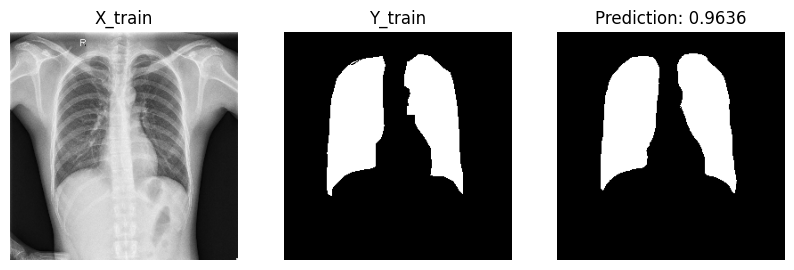

1/1 [==============================] - 0s 48ms/step - loss: 0.0477 - dice_coef: 0.9523


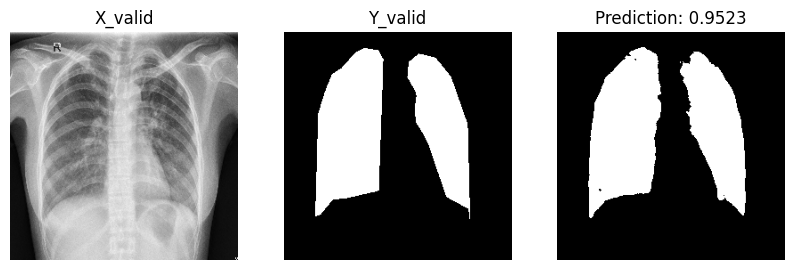

1/1 [==============================] - 0s 48ms/step - loss: 0.0481 - dice_coef: 0.9519


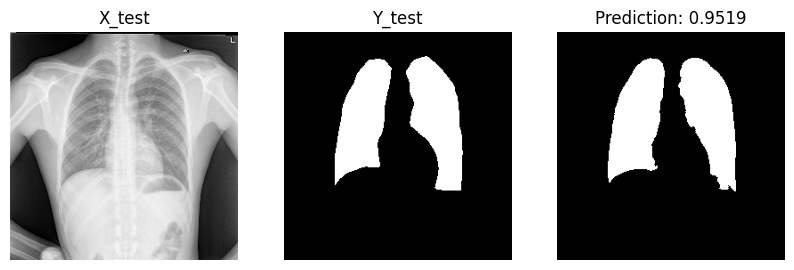

In [16]:
# model = load_model('best.h5')
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)